# Overview

Сreating a recommendation system using the collaborative filtering method based on matrix factorization (SVD). It predicts game ratings for users based on their past ratings and recommends games that users have not yet rated. The primary goal is to provide personalized recommendations that help users discover interesting games on the Steam platform.

In [1]:
pip install gdown

In [2]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357254 sha256=20d76684ee5e4171601ddf46e2d8ab4573e3d2a3ff9c0dac4067af3e20e54fdf
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [3]:
# imports
import gdown
import pandas as pd
import numpy as np
import json
import pickle
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import seaborn as sn
from surprise.model_selection import cross_validate

In [8]:
# downloading a file
file_id = '11SQ7kKA4MslkNrF6eq7u0sm541i1WH7d'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'sampled_data.csv'

gdown.download(url, output, quiet=False)

sampled_data = pd.read_csv(output)
sampled_data.head()

Downloading...
From (original): https://drive.google.com/uc?id=11SQ7kKA4MslkNrF6eq7u0sm541i1WH7d
From (redirected): https://drive.google.com/uc?id=11SQ7kKA4MslkNrF6eq7u0sm541i1WH7d&confirm=t&uuid=02013129-aae4-4278-81e5-c74df05a2302
To: /content/sampled_data.csv
100%|██████████| 247M/247M [00:03<00:00, 66.1MB/s]


,app_id,tags_string,user_id,title,rating_numeric
0,951440,"Open World Survival Craft, Survival, Open Worl...",9074881,Volcanoids,4.5
1,32440,"LEGO, Local Co-Op, Adventure, Co-op, Family Fr...",6006822,LEGO® Star Wars™ - The Complete Saga,5.0
2,615610,"Indie, Casual, Action, Space, 2D, Singleplayer...",1239,Orbt XL,5.0
3,1097840,"Action, Adventure, Multiplayer, Third-Person S...",9255103,Gears 5,3.5
4,464060,"Cyberpunk, Action, Top-Down Shooter, Great Sou...",5324004,RUINER,4.5


In [11]:
collaborative_df = sampled_data [['user_id', 'app_id', 'title', 'rating_numeric']]
collaborative_df.head()

,user_id,app_id,title,rating_numeric
0,9074881,951440,Volcanoids,4.5
1,6006822,32440,LEGO® Star Wars™ - The Complete Saga,5.0
2,1239,615610,Orbt XL,5.0
3,9255103,1097840,Gears 5,3.5
4,5324004,464060,RUINER,4.5


<ipython-input-12-b64a267cacba>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.countplot( x='rating_numeric' , data = collaborative_df ,


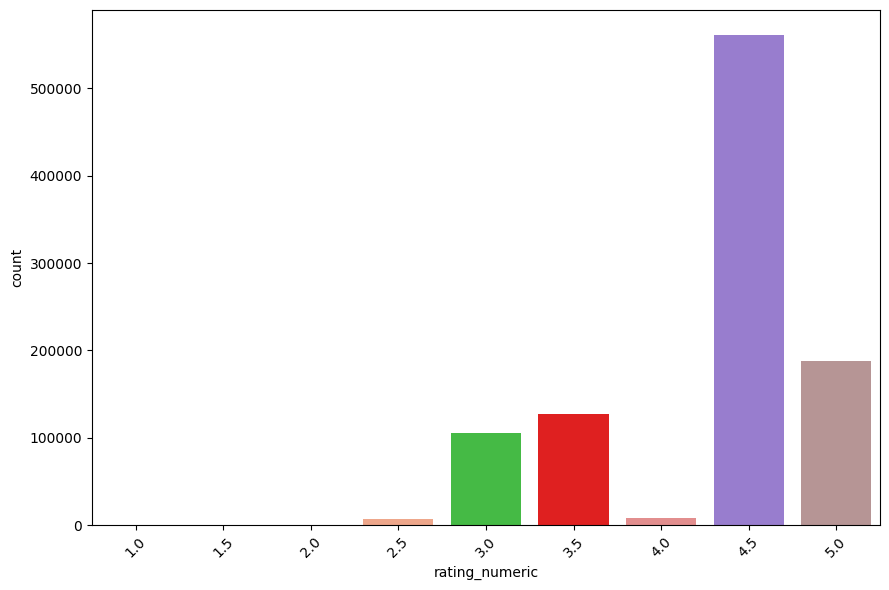

In [12]:
plt.figure(figsize=(9, 6))
sn.countplot( x='rating_numeric' , data = collaborative_df ,
    palette = [
    'DeepSkyBlue',        # 5.0 Very Positive
    'LightSkyBlue',       # 4.5 Positive
    'DarkOrange',         # 4.0 Mixed
    'LightSalmon',        # 3.5 Mostly Positive
    'LimeGreen',          # 3.0 Overwhelmingly Positive
    'Red',                # 2.5 Negative
    'LightCoral',         # 2.0 Mostly Negative
    'MediumPurple',       # 1.5 Overwhelmingly Negative
    'RosyBrown'           # 1.0 Very Negative
])
plt.xticks(rotation=45)
plt.title('Score Layout Visualization')
plt.tight_layout()

In [13]:
collaborative_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   user_id         1000000 non-null  int64  
 1   app_id          1000000 non-null  int64  
 2   title           1000000 non-null  object 
 3   rating_numeric  1000000 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 30.5+ MB


In [14]:
collaborative_df['user_id'] = collaborative_df['user_id'].astype('float32')
collaborative_df['app_id'] = collaborative_df['app_id'].astype('float32')
collaborative_df['rating_numeric'] = collaborative_df['rating_numeric'].astype('float32')

<ipython-input-14-8f9152466753>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collaborative_df['user_id'] = collaborative_df['user_id'].astype('float32')
<ipython-input-14-8f9152466753>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collaborative_df['app_id'] = collaborative_df['app_id'].astype('float32')
<ipython-input-14-8f9152466753>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

# Preparing data for SVD model

In [15]:
# downloading data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(collaborative_df[['user_id', 'app_id', 'rating_numeric']], reader)

# dividing the data into training and test data
trainset, testset = train_test_split(data, test_size=0.2)

# Model SVD

In [16]:
model = SVD()
model.fit(trainset)

In [17]:
# test
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')

RMSE: 0.1895
RMSE: 0.18946312252954234


# Cross-validation and model estimation

In [18]:
# using cross-validation to estimate the model
cross_val_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

# RMSE & MAE
mean_rmse = cross_val_results['test_rmse'].mean()
mean_mae = cross_val_results['test_mae'].mean()
print(f'Mean RMSE: {mean_rmse}')
print(f'Mean MAE: {mean_mae}')

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.2037  0.2017  0.2028  0.2027  0.0008  
MAE (testset)     0.0854  0.0846  0.0853  0.0851  0.0004  
Fit time          21.67   22.23   22.48   22.13   0.34    
Test time         5.89    2.70    2.51    3.70    1.55    
Mean RMSE: 0.20272424232845862
Mean MAE: 0.08508051635758906


# Prediction check

In [19]:
predictions = model.test(testset)
for prediction in predictions[:10]:  # output of the first 10 predictions
    print(f"User: {prediction.uid}, Item: {prediction.iid}, Actual Rating: {prediction.r_ui}, Predicted Rating: {prediction.est}")

User: 10230654.0, Item: 221380.0, Actual Rating: 5.0, Predicted Rating: 4.9855876863615896
User: 13006684.0, Item: 552450.0, Actual Rating: 4.5, Predicted Rating: 4.4632838910094925
User: 5664018.0, Item: 1056960.0, Actual Rating: 3.0, Predicted Rating: 3.0383065718651183
User: 5696620.0, Item: 274170.0, Actual Rating: 4.5, Predicted Rating: 4.494901214436889
User: 4993.0, Item: 298110.0, Actual Rating: 4.5, Predicted Rating: 4.487848187518251
User: 6721805.0, Item: 22610.0, Actual Rating: 3.5, Predicted Rating: 3.523356967354458
User: 9517654.0, Item: 1222690.0, Actual Rating: 3.5, Predicted Rating: 3.5063810182611688
User: 7452664.0, Item: 329440.0, Actual Rating: 3.0, Predicted Rating: 3.0656124097418016
User: 11678674.0, Item: 409720.0, Actual Rating: 3.0, Predicted Rating: 3.0110724431325164
User: 3823175.0, Item: 70600.0, Actual Rating: 4.5, Predicted Rating: 4.51603523833254


# Top-K recommendations for the specified user

In [20]:
def get_top_k_recommendations(model, user_id, games_df, collaborative_df, k=10):
    # get a list of all the games
    all_games = games_df['app_id'].unique()
    # getting a list of games that the user has already rated
    user_rated_games = collaborative_df[collaborative_df['user_id'] == user_id]['app_id']
    # exclusion of already rated games
    games_to_predict = [game for game in all_games if game not in user_rated_games]
    # predicting ratings for all unrated games
    predictions = [model.predict(user_id, game) for game in games_to_predict]
    # sorting forecasts by predicted rating
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:k]
    # getting information on top-K games
    top_games = [
        (pred.iid, collaborative_df[collaborative_df['app_id'] == pred.iid]['title'].iloc[0], pred.est)
        for pred in top_predictions
    ]

    return top_games

In [24]:
# entering the user ID and the number of recommendations
user_id = input("Enter the user ID: ")
k = int(input("Enter the number of recommendations: "))

Enter the user ID: 11892793
Enter the number of recommendations: 10


In [25]:
# top-K recommendations
top_k_games = get_top_k_recommendations(model, user_id, collaborative_df[['app_id']], collaborative_df, k)
print(f"Тоp-{k} user recommendations {user_id}:")
for app_id, title, est in top_k_games:
    print(f"Game ID: {app_id}, Title: {title}, Predicted Rating: {est}")

Тоp-10 user recommendations 11892793:
Game ID: 261180.0, Title: Lethal League, Predicted Rating: 4.993917959651524
Game ID: 4570.0, Title: Warhammer® 40000: Dawn of War® - Game of the Year Edition, Predicted Rating: 4.992551669631116
Game ID: 562220.0, Title: Zup! 2, Predicted Rating: 4.992293232858197
Game ID: 511470.0, Title: Glass Masquerade, Predicted Rating: 4.991928619989361
Game ID: 35700.0, Title: Trine Enchanted Edition, Predicted Rating: 4.991906572698225
Game ID: 230270.0, Title: N++ (NPLUSPLUS), Predicted Rating: 4.991647525768363
Game ID: 1147690.0, Title: NGU IDLE, Predicted Rating: 4.9916151450575
Game ID: 359050.0, Title: Shower With Your Dad Simulator 2015: Do You Still Shower With Your Dad, Predicted Rating: 4.990924752496756
Game ID: 593280.0, Title: Cat Quest, Predicted Rating: 4.9908989269675885
Game ID: 597760.0, Title: Yuppie Psycho: Executive Edition, Predicted Rating: 4.989804906891887


# Saving the model

In [26]:
from google.colab import drive
import pickle

drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/svd_model.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"The model is saved along the path: {model_path}")

Mounted at /content/drive
The model is saved along the path: /content/drive/MyDrive/svd_model.pkl
